In [155]:
import csv, os, glob
import numpy as np
import tensorflow as tf
import features as features_lib
import tensorflow as tf
import yamnet_short

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [156]:
parent_dir = "D:\\datasets\\UrbanSounds8K\\resampled_wav_16000"
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
classes = ['0_air_conditioner', '1_car_horn', '2_children_playing', '3_dog_bark', 
'4_drilling', '5_engine_idling', '6_gun_shot', '7_jackhammer', '8_siren', '9_street_music']

from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
def filenames_train_test(parent_dir, folds):
    for i, (train_index, test_index) in enumerate(kf.split(folds)):
        filenames_train, filenames_test = [],[]
        # print(folds[train_index], folds[test_index])
        for fold in folds[train_index]:
            filenames = glob.glob(os.path.join(parent_dir, fold, "*.wav"))
            filenames_train.extend(filenames)
        for fold in folds[test_index]:
            filenames = glob.glob(os.path.join(parent_dir, fold, "*.wav"))
            filenames_test.extend(filenames)
        yield (filenames_train, filenames_test)

for (x,y) in filenames_train_test(parent_dir, folds):
    print(len(x), len(y))

7859 873
7844 888
7807 925
7742 990
7796 936
7909 823
7894 838
7926 806
7916 816
7895 837


In [157]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
    # AddBackgroundNoise
    # AddShortNoises
])

# @tf.function
def augment_sample(augment, wave):
    wave = augment(samples=wave, sample_rate=16000)  
    return wave

import params as yamnet_params
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)
  
def get_label(filename):
    label = tf.strings.split(filename, "\\")[-1]
    label = tf.strings.split(label, "-")[1]
    length = len(get_embedding(filename))
    try: 
      label = tf.repeat(label, length)
    except:
      pass
    label = tf.cast(int(label), dtype='int32')
    return label

def get_waveform_no_label(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, dtype=tf.float32)
  return waveform

@tf.function
def get_embedding(filename, AUGMENT=False):
  params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.5)
  waveform = get_waveform_no_label(filename)
  if AUGMENT==True:
    waveform = augment_sample(augment, waveform)
  waveform_padded = features_lib.pad_waveform(waveform, params)
  log_mel_spectrogram, features = features_lib.waveform_to_log_mel_spectrogram_patches(
      waveform_padded, params)
  return tf.expand_dims(features, axis=-1)
  # return log_mel_spectrogram


In [161]:
# Create a dataset of filenames
def get_dataset(filenames, augment_flag=False, training=True):
  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  # Map the filenames to the embeddings
  dataset_samples_noaugment = dataset.map(
    map_func = lambda x: tf.py_function(get_embedding, inp=[x, False], Tout=tf.float32, name=None),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  # dataset_samples_augment = dataset.map(
  #   map_func = lambda x: tf.py_function(get_embedding, inp=[x, augment_flag], Tout=tf.float32, name=None),
  #   num_parallel_calls=tf.data.AUTOTUNE
  # )
  # dataset_samples_combined = dataset_samples_noaugment.concatenate(dataset_samples_augment)
  dataset_samples_combined = dataset_samples_noaugment
  dataset_labels = dataset.map(get_label)
  # dataset_labels_combined = dataset_labels.concatenate(dataset_labels)
  dataset_labels_combined = dataset_labels

  if training==True:
    # Flatmap the embeddings to squeeze dim=0 and then zip the samples and labels
    dataset_samples_combined = dataset_samples_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
    dataset_labels_combined = dataset_labels_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

  dataset = dataset.zip((dataset_samples_combined, dataset_labels_combined))
  return dataset


    658/Unknown - 59s 81ms/step - loss: 1.3434 - accuracy: 0.5309
Epoch 1: saving model to ./training/20220407-021405/fold0/checkpoints\cp.ckpt
659/659 [==============================] - 78s 110ms/step - loss: 1.3430 - accuracy: 0.5311 - val_loss: 1.4795 - val_accuracy: 0.5206
INFO:tensorflow:Assets written to: ./training/20220407-021405/fold0/model.hd5\assets
873/873 - 8s - loss: 1.8502 - accuracy: 0.4169 - 8s/epoch - 9ms/step
Testing accuracy:  0.4558991981672394
    660/Unknown - 45s 61ms/step - loss: 1.3953 - accuracy: 0.5104
Epoch 1: saving model to ./training/20220407-021718/fold1/checkpoints\cp.ckpt
660/660 [==============================] - 56s 78ms/step - loss: 1.3953 - accuracy: 0.5104 - val_loss: 1.3242 - val_accuracy: 0.5547
INFO:tensorflow:Assets written to: ./training/20220407-021718/fold1/model.hd5\assets
888/888 - 7s - loss: 1.8577 - accuracy: 0.3864 - 7s/epoch - 7ms/step
Testing accuracy:  0.40653153153153154
    654/Unknown - 47s 64ms/step - loss: 1.3437 - accuracy: 0

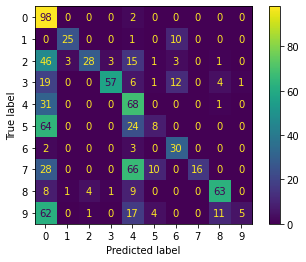

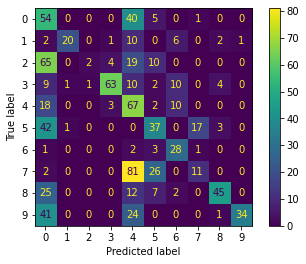

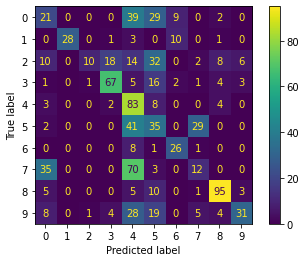

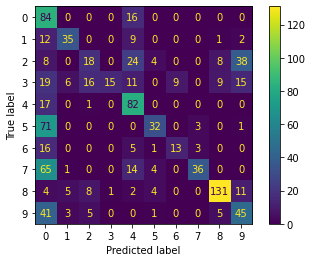

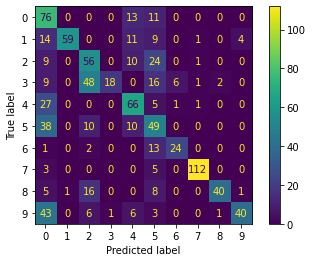

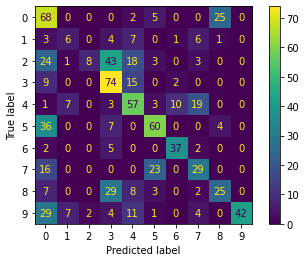

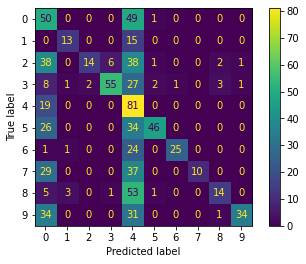

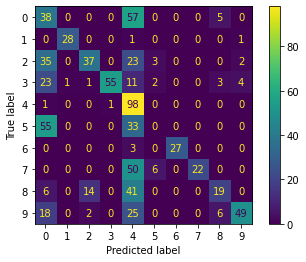

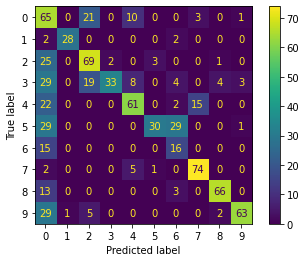

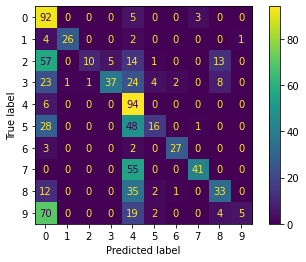

In [163]:
import datetime

for i, (filenames_train, filenames_test) in enumerate(filenames_train_test(parent_dir, folds)):  
    AUTOTUNE = tf.data.AUTOTUNE
    random.shuffle(filenames_train)
    length = len(filenames_train)
    train_dataset = get_dataset(filenames_train[:int(length*0.75)], augment_flag=True, training=True)
    eval_dataset = get_dataset(filenames_train[int(length*0.75):], augment_flag=True, training=True)
    train_dataset = train_dataset.batch(64).cache().prefetch(AUTOTUNE)
    eval_dataset = eval_dataset.batch(64).cache().prefetch(AUTOTUNE)
        
    # print("Length of train, eval, test datasets:", len(list(train_dataset)),len(list(eval_dataset)),len(list(test_dataset)))
    
    # Paths
    training_path = "./training/{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    ckp_path = training_path + "/fold{}/checkpoints/cp.ckpt".format(i)
    log_path = training_path + "/fold{}/logs/fit".format(i)       
    hd5_path = training_path + "/fold{}/model.hd5".format(i)
    cfm_path = training_path + "/fold{}/confusion_matrix.png".format(i)
    
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    # Create a tensorboard callback                         
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
    
    # Declare model
    Yamnet_Short = yamnet_short.Yamnet_short()
    yamnet_model = Yamnet_Short.model()
    yamnet_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    # yamnet_model.summary()

    # Fit model
    yamnet_model.fit(train_dataset, validation_data = eval_dataset, epochs=1, 
        verbose=1, callbacks=[cp_callback,tensorboard_callback])

    # Save HD5 model from final epoch 
    yamnet_model.save(hd5_path)
    # new_model = tf.keras.models.load_model('my_model.h5')

    # Evaluate performance of model with test fold (that it wasn't trained on)
    test_dataset = get_dataset(filenames_test, augment_flag=False, training=False).cache().prefetch(AUTOTUNE)
    yamnet_model.load_weights(ckp_path)
    loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)
    # print(acc)

    test_samples = test_dataset.map(lambda x,y: x)
    test_labels = test_dataset.map(lambda x,y: y[0])

    # Get y_preds = predictions made by model
    y_preds = []
    for x in test_samples:
        y_pred = tf.argmax(tf.math.reduce_sum(yamnet_model.predict(x), axis=0))
        y_preds.append(y_pred)

    y_preds = np.array(y_preds)

    # Get y_true = actual labels
    def get_numpy(a_list):
        for b in a_list:
            yield b.numpy()

    y_true = np.array([b for b in get_numpy(list(test_labels))])
    accuracy = accuracy_score(y_true, y_preds)
    print("Testing accuracy: ", accuracy)
    cm = ConfusionMatrixDisplay.from_predictions(y_true, y_preds)
    cm.figure_.savefig(cfm_path,dpi=500)
